# Analyze distances from tokens to regions of interest

In [97]:
print('Notebook is working.')
%load_ext autoreload
%autoreload 2
import os
os.environ['TRANSFORMERS_CACHE'] = '/atlas/u/pkalluri/.cache'
import sys
sys.path.insert(0, os.path.abspath('../../..'))  # distances --> vis-wiki --> analysis-and-vis --> src
# This form of import is reasonable research practice because many directories may want to use the same utils,
# but note that this is a bad practice for publishing packages because directories should be modular, with all utils inside them.
# Consider changing before publicly publishing code.
# load
from utils import references as refs
import pickle
import numpy as np
from utils.Token import Token
from utils.misc_util import select_layers
from collections import Counter
# process
import random
from utils.ModelType import ModelType, get_generic, berts, gpts
from utils.MyModel import MyModel
# calculate distances
from utils.acts_util import get_angles, get_euclidean_distances
import pandas as pd
# vis
import plotly.express as px
from utils.plotly_util import get_error_bands, combine_figs

Notebook is working.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Params

In [98]:
# Model and data params
model_type = ModelType.gpt2
dataset_dir = f"/atlas/u/pkalluri/bert-vis/big-data/{get_generic(model_type)}/{model_type.value}/"
n_layers = None  # None results in analyzing all layers

In [99]:
model = MyModel(model_type=model_type)
dataset_dir = os.path.abspath(dataset_dir)
dataset_toks = [Token(doc,pos,model_type) for doc,pos in pickle.load(open(os.path.join(dataset_dir, refs.toks_fn),'rb'))]
types_counts = Counter([tok.type for tok in dataset_toks])
dataset_acts = np.load(os.path.join(dataset_dir, refs.acts_fn))
layers = select_layers(list(dataset_acts), n_layers)

## Minimal investigation

In [87]:
# Nice for finding short sentences in the dataset
[(i,tok.text) for i, tok in enumerate(dataset_toks) if tok.len < 6]

[(1799, '[[August]] 1'),
 (1800, 'August[[ 1]]'),
 (2137, '[[<]]br>'),
 (2138, '<[[br]]>'),
 (2139, '<br[[>]]'),
 (8936, '[[<]]br>'),
 (8937, '<[[br]]>'),
 (8938, '<br[[>]]'),
 (11905, '[[There]] is 1 street.'),
 (11906, 'There[[ is]] 1 street.'),
 (11907, 'There is[[ 1]] street.'),
 (11908, 'There is 1[[ street]].'),
 (11909, 'There is 1 street[[.]]'),
 (13048, '[[R]]. Cohen)'),
 (13049, 'R[[.]] Cohen)'),
 (13050, 'R.[[ Cohen]])'),
 (13051, 'R. Cohen[[)]]'),
 (13263, '[[19]]44 in comics'),
 (13264, '19[[44]] in comics'),
 (13265, '1944[[ in]] comics'),
 (13266, '1944 in[[ comics]]'),
 (13311, '[[Ac]]ademy.'),
 (13312, 'Ac[[ad]]emy.'),
 (13313, 'Acad[[emy]].'),
 (13314, 'Academy[[.]]'),
 (14800, '[[e]].g.'),
 (14801, 'e[[.]]g.'),
 (14802, 'e.[[g]].'),
 (14803, 'e.g[[.]]'),
 (15236, '[[<]]br>'),
 (15237, '<[[br]]>'),
 (15238, '<br[[>]]'),
 (16386, '[[The]] six ships were:'),
 (16387, 'The[[ six]] ships were:'),
 (16388, 'The six[[ ships]] were:'),
 (16389, 'The six ships[[ were]]:'),
 (

In [88]:
# Choose a tok and load act
tok_id = 19513
layer = 'arr_0'
tok = dataset_toks[tok_id]
tok_act = dataset_acts[layer][tok_id]
tok.text, tok_act[:4]

('There are 7[[ streets]].',
 array([-0.05483913, -0.01580619,  0.09264714, -0.01732198], dtype=float32))

In [89]:
# From untokenized string, calculate this act. Tokenization of middle tokens is strage but act matches!
doc_str = ''.join(tok.doc)
print(doc_str)
print()

tokenization = model.tokenizer(doc_str, return_tensors="pt")['input_ids']
print("Tokenized ids: ", tokenization)
print("In human readable form: ", model.tokenizer.convert_ids_to_tokens(tokenization[0]))
print()

doc_toks, doc_acts = model.get_doc_acts(doc_str)
_doc_acts = doc_acts[layer]
[(doc_tok, doc_act[:4]) for doc_tok, doc_act in zip(doc_toks, _doc_acts)][3]

There are 7 streets.

Tokenized ids:  tensor([[1858,  389,  767, 6483,   13]])
In human readable form:  ['There', 'Ġare', 'Ġ7', 'Ġstreets', '.']



('streets',
 array([-0.05483913, -0.01580619,  0.09264714, -0.01732198], dtype=float32))

In [90]:
# From token, freshly calculate act. Tokenization of middle tokens is strange and activation is wrong!
print(doc)
print()

tok_act = model.get_tok_acts(tok)[layer]
tokenization = model.tokenizer.convert_tokens_to_ids(tok.doc)
print("Tokenized ids: ", tokenization)
print("In human readable form: ", model.tokenizer.convert_ids_to_tokens(tokenization[0]))
print()

tok.text, tok_act[:4]

['There', ' are', ' 7', ' streets', '.']

Tokenized ids:  [1858, 50256, 50256, 50256, 13]
In human readable form:  There



('There are 7[[ streets]].',
 array([ 0.05106865, -0.10149168,  0.15546337, -0.04156054], dtype=float32))

## Full experiment

### Set up model and choose tokens

In [100]:
# Other params
title = ''

# Number of center tokens to analyze
n_tokens = 10

# Any center tokens, or specific kinds of tokens? e.g. Do you want to know if frequent tokens get farther from their type balls?
filt = ''  # None or 'frequent.__' or 'partial' or 'top'

# How many samples would you like to compare to? i.e. How big would you like the subcorpora and custom corpora to be? 
n_samples = 10

n_layers = None  # None results in analyzing all layers

# Where to save the data
output_dir = 'distances'

# Tag to attach to saved data. e.g. to indicate something special about this run.
tag = ''

In [101]:
# Restrict, constructing a smaller corpus
if filt in ['', ' ', None]:
    f = lambda tok: not tok.is_special
elif filt=='partial':
    f = lambda tok: tok.is_partial
elif filt.startswith('frequent'): # e.g. get elements arund the 90th percentile
    start = float(filt.split('frequent')[1]) * len(types_counts)
    valid_types = types_counts.most_common()[::-1][start:start+n_samples]
    f = lambda tok: tok.type in valid_types and not tok.is_special
elif filt=='top':
    top_n, _ = zip(*types_counts.most_common(n_tokens+2))
    f = lambda tok: tok.type in top_n and not tok.is_special
# Note: these tokens are all unique - however there may be duplicates of the same type
candidate_ids = list(filter(lambda tok_id: f(dataset_toks[tok_id]), range(len(dataset_toks))))
# print(candidate_ids)
tok_ids = random.sample(candidate_ids, n_tokens) # Sampling from the valid corpus
print('Types: ', ' '.join([dataset_toks[tok_id].type for tok_id in tok_ids]))

Types:   Southern  into 

  and ,  company  less  A formerly  the


### Choose subcorpora of tokens and recipes for custom tokens (e.g. the type set and the context set)

In [102]:
# Define
filters = {}
filters['Random tokens'] = lambda main_tok, candidate_tok: not candidate_tok.is_edge
filters[f'Same type, in naturally occurring contexts'] = lambda tok1, tok2: tok1 != tok2 and tok1.same_type(tok2)

In [103]:
# Apply each filter, constructing the subcorpora of interest
subcorpora = {filter_:{tok_id:[] for tok_id in tok_ids}  for filter_ in filters}
# e.g. a subcorpus is filter ("same type") as this token ("...caught...")
for candidate_tok_id in range(len(dataset_toks)):  # scan through dataset for relevant tokens
    candidate_tok = dataset_toks[candidate_tok_id]
    for tok_id in tok_ids:
        tok = dataset_toks[tok_id]
        for filter_, f in filters.items():
            subcorpus = subcorpora[filter_][tok_id]
            if len(subcorpus) < n_samples and f(tok, candidate_tok):  
                # continue gathering points relevant to this subcorpus
                subcorpus.append(candidate_tok_id)

## Choose subcorpora to compare to
Choose subcorpora of entire dataset, to see how far away a token is from this subcorpus.

e.g. you might interested in how far away tokens are from their type ball (tokens of same type).

In [29]:
# Define
filters = {}
filters['Random tokens'] = lambda main_tok, candidate_tok: not candidate_tok.is_edge
filters[f'Same type, in naturally occurring contexts'] = lambda tok1, tok2: tok1 != tok2 and tok1.same_type(tok2)
filters[f'Same successor, in naturally occurring contexts'] = (
    lambda tok1, tok2: tok1.same_next(tok2) and not tok1.same_type(tok2) and not tok2.is_edge)
filters[f'Same bigram, natural'] = (
    lambda tok1, tok2: tok1.same_type(tok2) and tok1.same_next(tok2) and not tok2.is_edge)
filters[f'Partner in bigram, natural'] = (
    lambda tok1, tok2: tok2.prev == tok1.type and tok1.next == tok2.type and not tok2.is_edge)

In [30]:
# Apply each filter, constructing the subcorpora of interest
subcorpora = {filter_:{tok_id:[] for tok_id in tok_ids}  for filter_ in filters}
# e.g. a subcorpus is filter ("same type") as this token ("...caught...")
for candidate_tok_id in range(len(dataset_toks)):  # scan through dataset for relevant tokens
    candidate_tok = dataset_toks[candidate_tok_id]
    for tok_id in tok_ids:
        tok = dataset_toks[tok_id]
        for filter_, f in filters.items():
            subcorpus = subcorpora[filter_][tok_id]
            if len(subcorpus) < n_samples and f(tok, candidate_tok):  
                # continue gathering points relevant to this subcorpus
                subcorpus.append(candidate_tok_id)

## Create custom corpora to compare to 
e.g. You may be interested in comparing this token to the same type dropped into random contexts

In [104]:
# Define
recipes = {}
random_toks = random.choices(
    list(filter(lambda tok: not tok.is_special and not tok.is_edge, dataset_toks)), 
    k=n_samples)
recipes[f'Same type, dropped into random contexts'] = lambda tok: tok.in_contexts(random_toks)

In [105]:
# Apply recacts_utiles, to construct the custom corpora to compare to
custom_corpora = {}
print('Constructing corpora...')
for recipe, f in recipes.items():
    print(recipe)
    custom_corpora[recipe] = {tok_id: f(dataset_toks[tok_id]) for tok_id in tok_ids}  # a custom corpus is e.g. "tokens in doc" of this specific doc
print('\nPulling activations...')
custom_corpora_acts = {}
for recipe in recipes:
    print(recipe)
    custom_corpora_acts[recipe] = {tok_id: model.get_toks_acts(custom_toks) for tok_id, custom_toks in custom_corpora[recipe].items()}        

Constructing corpora...
Same type, dropped into random contexts

Pulling activations...
Same type, dropped into random contexts


### Calculating distances to tokens of interest

In [106]:
# Params
get_distances = get_angles # metric
n_layers=4
layers = select_layers(list(dataset_acts), n_layers)

In [107]:
# Calculate
distances = pd.DataFrame()
dim = dataset_acts[layers[0]][0].shape[0]
for layer in layers:
    print(layer)
    _dataset_acts = dataset_acts[layer]
    for tok_id in tok_ids:
        tok = dataset_toks[tok_id]
        _tok_act = _dataset_acts[tok_id]
        # filters on dataset
        for filter_ in filters:
            subcorpus_ids = subcorpora[filter_][tok_id]
            subcorpus_distances = {
                'other token': [dataset_toks[id_] for id_ in subcorpus_ids],
                'distance': get_distances(_dataset_acts[subcorpus_ids], _tok_act),
                'layer': [layer,] * len(subcorpus_ids),
                'key': [filter_,] * len(subcorpus_ids),
                'main token': [tok,] * len(subcorpus_ids)}
            distances = pd.concat([distances, pd.DataFrame(subcorpus_distances)], ignore_index=True)
            del subcorpus_distances
        # custom corpora
        for recipe in recipes:
            custom_corpus = custom_corpora[recipe][tok_id]
            _custom_corpus_acts = custom_corpora_acts[recipe][tok_id][layer]
            custom_corpus_distances = {
                'other token': custom_corpus,
                'distance': get_distances(_custom_corpus_acts, _tok_act),
                'layer': [layer,] * len(custom_corpus),
                'key': [recipe,] * len(custom_corpus),
                'main token': [tok,] * len(custom_corpus)}
            distances = pd.concat([distances, pd.DataFrame(custom_corpus_distances)], ignore_index=True)
            del custom_corpus_distances

arr_0
arr_4
arr_8
arr_12



### Visualize

In [108]:
# Setup
layers = distances['layer'].unique().tolist()
# distances - pull from csv
for layer in layers:
    median_rand = distances[(distances.key=='Random tokens') & (distances.layer==layer)]['distance'].median()
    distances.loc[distances.layer==layer, 'normalized distance'] = distances[distances.layer==layer]['distance']/median_rand
median = pd.concat([pd.DataFrame(dict(layer=layers)), 
                   pd.DataFrame({key: [distances[(distances.layer==layer) & (distances.key==key)]['normalized distance'].quantile(.5) for layer in layers] for key in keys})],
                   axis=1)
q1 = pd.concat([pd.DataFrame(dict(layer=layers)), 
                   pd.DataFrame({key: [distances[(distances.layer==layer) & (distances.key==key)]['normalized distance'].quantile(.25) for layer in layers] for key in keys})],
                   axis=1)
q3 = pd.concat([pd.DataFrame(dict(layer=layers)), 
                   pd.DataFrame({key: [distances[(distances.layer==layer) & (distances.key==key)]['normalized distance'].quantile(.75) for layer in layers] for key in keys})],
                   axis=1)

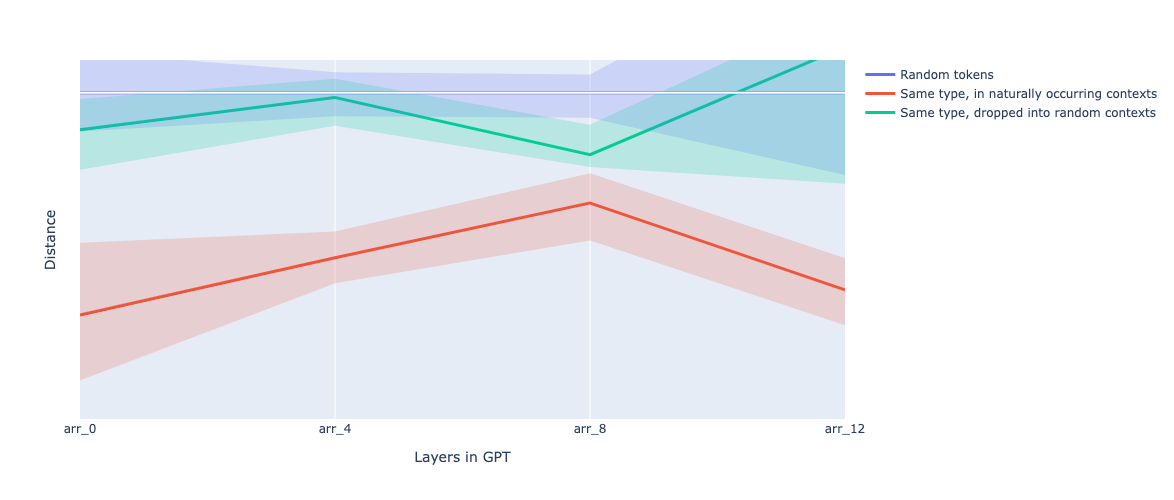

In [110]:
title = ''
lines = px.line(median, x='layer', y=keys, width=900, height=500, labels={"variable": ""}, title=title).update_traces(line=dict(width=3))
bands = get_error_bands(keys, q1,q3, layers)

# Tweaks
upper_bound = px.line(x=layers, y=[1,]*len(layers), color_discrete_sequence=['white',])
fig = combine_figs([lines, bands, upper_bound])
fig.update_yaxes(title='Distance', range=[0, 1.1], showticklabels=False, showgrid=False, nticks=2)
fig.update_xaxes(title=f'Layers in {get_generic(model_type).upper()}', showticklabels=True, tickvals=layers)
fig.update_layout(title_x=0.1, title_y=.85)
fig